# Training in Brax

Once an environment is created in brax, we can quickly train it using brax's built-in training algorithms. Let's try it out!

In [1]:
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a GPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'GPU'** in the dropdown.

import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output

try:
  import brax
except ImportError:
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

First let's pick an environment and a backend to train an agent in.

Recall from the [Brax Basics](https://github.com/google/brax/blob/main/notebooks/basics.ipynb) colab, that the backend specifies which physics engine to use, each with different trade-offs between physical realism and training throughput/speed. The engines generally decrease in physical realism but increase in speed in the following order: `generalized`,  `positional`, then `spring`.


In [2]:
#@title Load Env { run: "auto" }

env_name = 'pusher'  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'inverted_pendulum', 'inverted_double_pendulum', 'pusher', 'reacher', 'walker2d']
backend = 'positional'  # @param ['generalized', 'positional', 'spring']

env = envs.get_environment(env_name=env_name,
                           backend=backend)
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

HTML(html.render(env.sys, [state.pipeline_state]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Training

Brax provides out of the box the following training algorithms:

* [Proximal policy optimization](https://github.com/google/brax/blob/main/brax/training/agents/ppo/train.py)
* [Soft actor-critic](https://github.com/google/brax/blob/main/brax/training/agents/sac/train.py)
* [Evolutionary strategy](https://github.com/google/brax/blob/main/brax/training/agents/es/train.py)
* [Analytic policy gradients](https://github.com/google/brax/blob/main/brax/training/agents/apg/train.py)
* [Augmented random search](https://github.com/google/brax/blob/main/brax/training/agents/ars/train.py)

Trainers take as input an environment function and some hyperparameters, and return an inference function to operate the environment.

# Training

Let's train the Ant policy using the `generalized` backend with PPO.

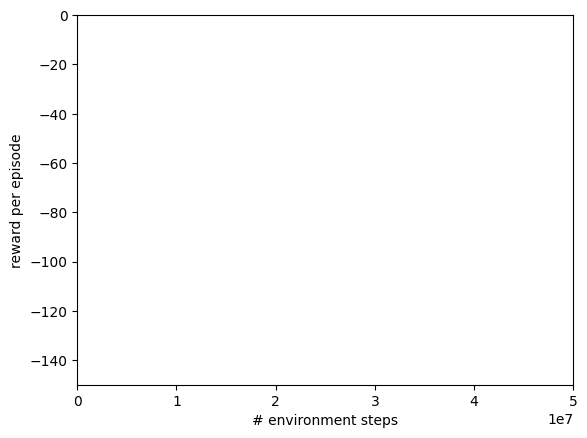

time to jit: 0:00:41.662301
time to train: 0:17:02.156475


In [3]:
#@title Training

# We determined some reasonable hyperparameters offline and share them here.
train_fn = {
  'inverted_pendulum': functools.partial(ppo.train, num_timesteps=2_000_000, num_evals=20, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, seed=1),
  'inverted_double_pendulum': functools.partial(ppo.train, num_timesteps=20_000_000, num_evals=20, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, seed=1),
  'ant': functools.partial(ppo.train,  num_timesteps=50_000_000, num_evals=10, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=4096, batch_size=2048, seed=1),
  'humanoid': functools.partial(ppo.train,  num_timesteps=50_000_000, num_evals=10, reward_scaling=0.1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=10, num_minibatches=32, num_updates_per_batch=8, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048, batch_size=1024, seed=1),
  'reacher': functools.partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=4, unroll_length=50, num_minibatches=32, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048, batch_size=256, max_devices_per_host=8, seed=1),
  'humanoidstandup': functools.partial(ppo.train, num_timesteps=100_000_000, num_evals=20, reward_scaling=0.1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=15, num_minibatches=32, num_updates_per_batch=8, discounting=0.97, learning_rate=6e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, seed=1),
  'hopper': functools.partial(sac.train, num_timesteps=6_553_600, num_evals=20, reward_scaling=30, episode_length=1000, normalize_observations=True, action_repeat=1, discounting=0.997, learning_rate=6e-4, num_envs=128, batch_size=512, grad_updates_per_step=64, max_devices_per_host=1, max_replay_size=1048576, min_replay_size=8192, seed=1),
  'walker2d': functools.partial(sac.train, num_timesteps=7_864_320, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=1, discounting=0.997, learning_rate=6e-4, num_envs=128, batch_size=128, grad_updates_per_step=32, max_devices_per_host=1, max_replay_size=1048576, min_replay_size=8192, seed=1),
  'halfcheetah': functools.partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=20, num_minibatches=32, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4, entropy_cost=0.001, num_envs=2048, batch_size=512, seed=3),
  'pusher': functools.partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=30, num_minibatches=20, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4,entropy_cost=1e-2, num_envs=2048, batch_size=512, seed=3),
}[env_name]


max_y = {'ant': 8000, 'halfcheetah': 8000, 'hopper': 2500, 'humanoid': 13000, 'humanoidstandup': 75_000, 'reacher': 5, 'walker2d': 5000, 'pusher': 0}[env_name]
min_y = {'reacher': -100, 'pusher': -150}.get(env_name, 0)

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

The trainers return an inference function, parameters, and the final set of metrics gathered during evaluation.

# Saving and Loading Policies

Brax can save and load trained policies:

In [4]:
model.save_params('/tmp/params', params)
params = model.load_params('/tmp/params')
inference_fn = make_inference_fn(params)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The trainers return an inference function, parameters, and the final set of metrics gathered during evaluation.

# Saving and Loading Policies

Brax can save and load trained policies:

In [5]:
#@title Visualizing a trajectory of the learned inference function

# create an env with auto-reset
env = envs.create(env_name=env_name, backend=backend)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  act, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_env_step(state, act)

HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))

🙌 See you soon!